In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor

%matplotlib inline

In [2]:
train_data = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")
test_data = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")

In [3]:
train_data.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy


In [4]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data.set_index('Date', inplace=True)

We have **converted the Date field of the train_data DataFrame to a datetime object** using the pd.to_datetime() function.
And set the **Date column as the index of the train_data DataFrame** using the set_index() function.

In [5]:
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data.set_index('Date', inplace=True)

Applied the above procedure for the test data as well

# Predicting

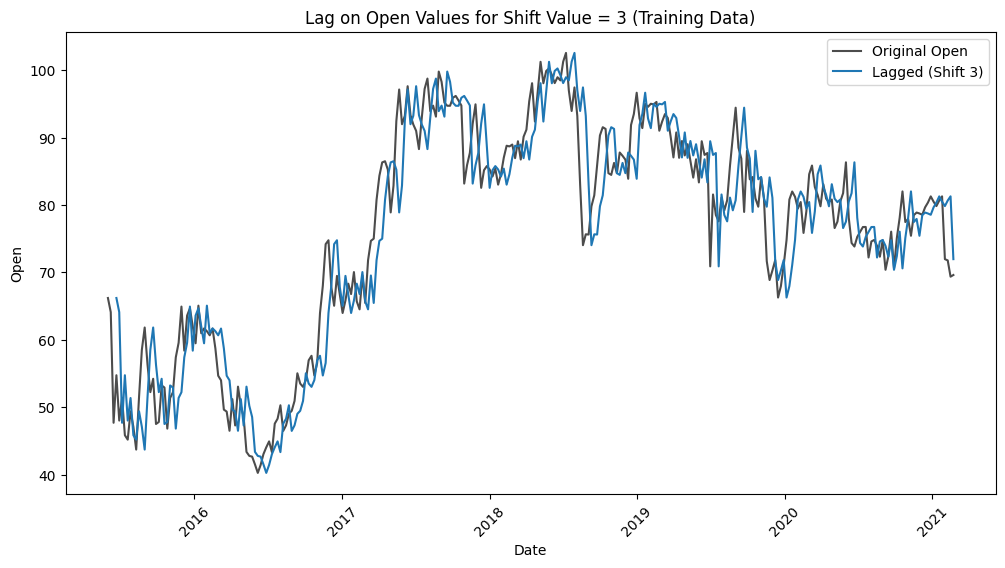

In [6]:
plt.figure(figsize=(12, 6))

plt.plot(train_data.index, train_data['Open'], label='Original Open', color='black', alpha=0.7)

lagged_series = train_data['Open'].shift(3)
plt.plot(train_data.index, lagged_series, label=f'Lagged (Shift 3)')

plt.xlabel('Date')
plt.ylabel('Open')
plt.title('Lag on Open Values for Shift Value = 3 (Training Data)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

* **Created a lagged series of the Open column** in the train_data DataFrame by shifting the data by 3 time periods, which means that the lagged series contains the open prices from 3 days ago.
* We have then plotted the lagged series on the same plot as the original Open column to analyze the relationship between the current open price and the open price from previous time periods.

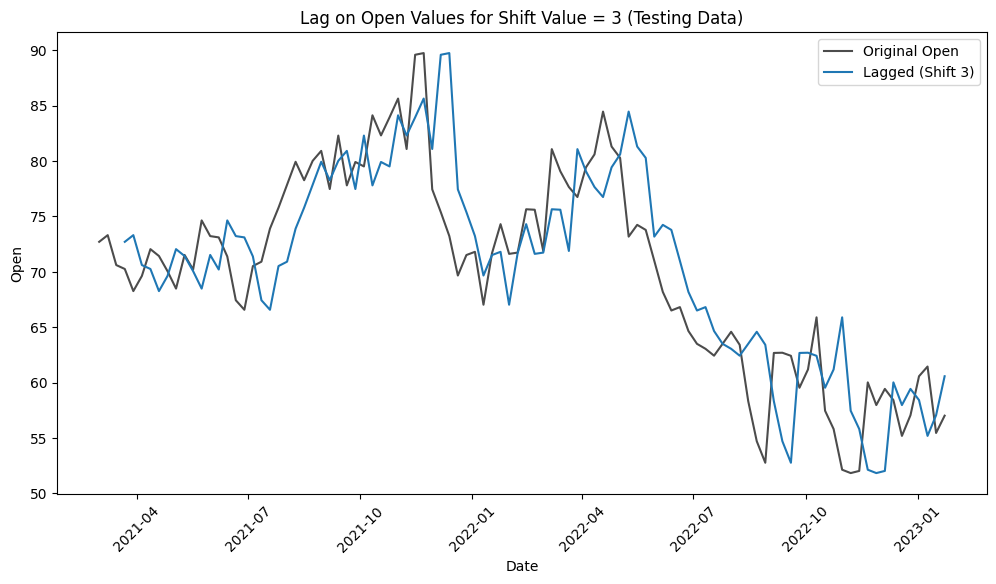

In [7]:
plt.figure(figsize=(12, 6))

plt.plot(test_data.index, test_data['Open'], label='Original Open', color='black', alpha=0.7)

lagged_series = test_data['Open'].shift(3)
plt.plot(test_data.index, lagged_series, label=f'Lagged (Shift 3)')

plt.xlabel('Date')
plt.ylabel('Open')
plt.title('Lag on Open Values for Shift Value = 3 (Testing Data)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [8]:
train_data['Open_reg'] = train_data['Open'].shift(3)
test_data['Open_reg'] = test_data['Open'].shift(3)

train_data['Open_reg'].fillna(train_data['Open'], inplace=True)
test_data['Open_reg'].fillna(test_data['Open'], inplace=True)

Created a new feature called **Open_reg** in the train and test dataframes containing the open prices from 3 days ago.
Filled in missing values in the Open_reg column with the **current open price**.

This creates a new column that contains the target variable - the open price for the previous 3 days. This information is then be used by the regression model to predict the open price for the current day.

In [9]:
X_train_reg = train_data[['Open_reg', 'Volume']]
y_train_reg = train_data['Close']

X_test_reg = test_data[['Open_reg', 'Volume']]

Splitted the train and test data into X and y dataframes, which is necessary for training and evaluating the regression model.

In [10]:
scaler = StandardScaler().fit(X_train_reg)
X_train_reg = scaler.transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

Scaled the train and test dataframes to ensure that the features are on a similar scale to be able to perform regression better

In [11]:
xgb_reg_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=2,
    gamma=0.2,
    reg_alpha=0.1,
    reg_lambda=0.1,
    eval_metric='mape'
)

svm_reg_model = SVR(kernel='linear', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.2, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

Creating two regression models, a Gradient Boosting Regressor (XGBRegressor) and a Support Vector Regressor (SVR).

In [12]:
voting_reg_model = VotingRegressor(
      estimators=[('xgb', xgb_reg_model), ('svm', svm_reg_model)],
      weights=[2, 3],
      n_jobs=-1,
)

voting_reg_model.fit(X_train_reg, y_train_reg)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='mape',
                                          feature_types=None, gamma=0.2,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=2,
                                          max_leaves=None, min_child_weight=2,
                                          missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=1000, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...)),
                            ('svm', SVR(epsilon=0.2, kernel='linear'))],
                n_jobs=-1, weights=[2, 3])

VotingRegressor ensemble model with GradientBoostingRegressor and SupportVectorRegressor base models, with weights of 2 and 3 respectively, trained on the X_train_reg and y_train_reg data.

In [13]:
test_data['Close'] = voting_reg_model.predict(X_test_reg)

# classifying

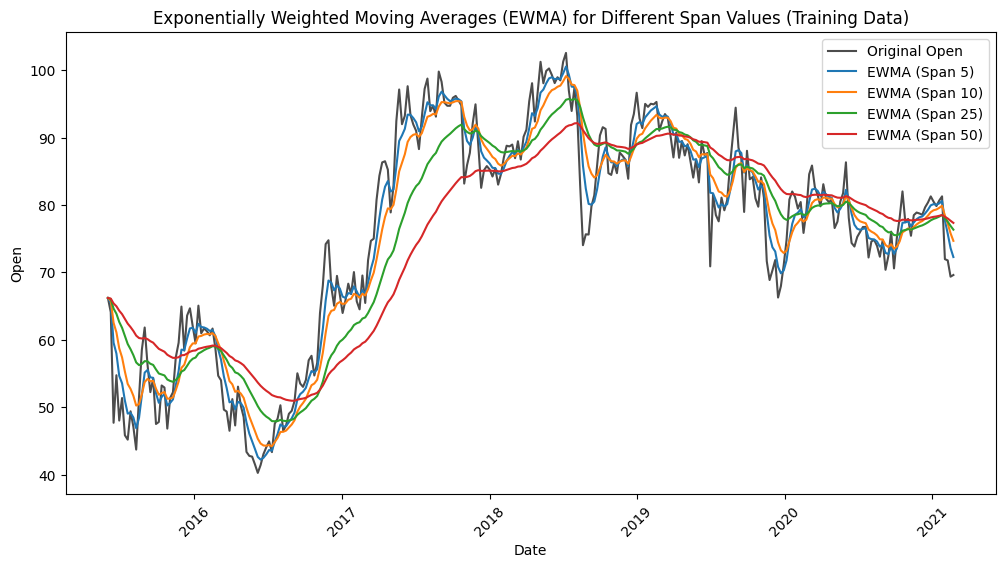

In [14]:
span_values = [5, 10, 25, 50]

plt.figure(figsize=(12, 6))

plt.plot(train_data.index, train_data['Open'], label='Original Open', color='black', alpha=0.7)

for span in span_values:
    ewma_values = train_data['Open'].ewm(span=span, adjust=False).mean()
    plt.plot(train_data.index, ewma_values, label=f'EWMA (Span {span})')

plt.xlabel('Date')
plt.ylabel('Open')
plt.title('Exponentially Weighted Moving Averages (EWMA) for Different Span Values (Training Data)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Plotting the **exponentially weighted moving averages (EWMA)** of the open price of the **training data** for different span values 

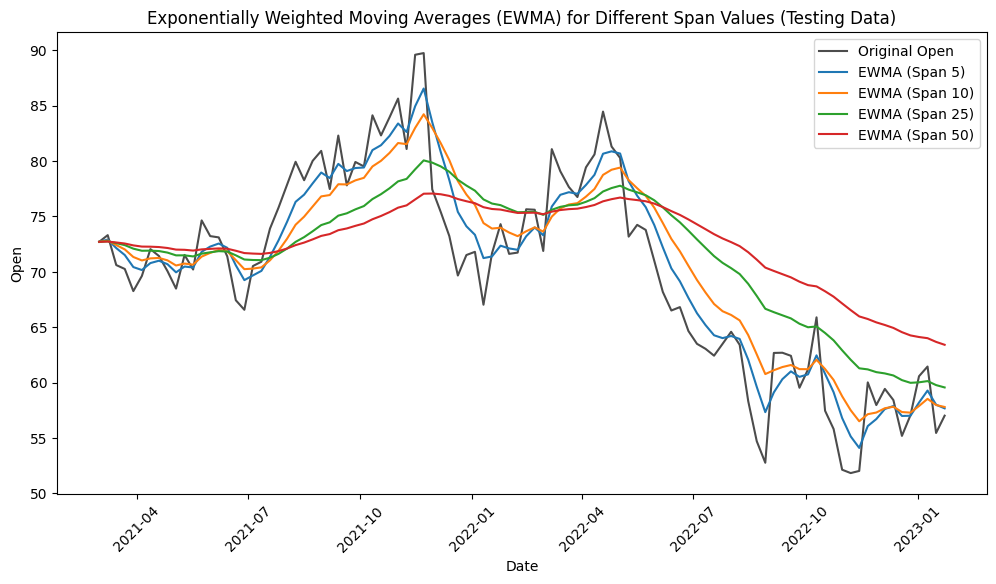

In [15]:
span_values = [5, 10, 25, 50]

plt.figure(figsize=(12, 6))

plt.plot(test_data.index, test_data['Open'], label='Original Open', color='black', alpha=0.7)

for span in span_values:
    ewma_values = test_data['Open'].ewm(span=span, adjust=False).mean()
    plt.plot(test_data.index, ewma_values, label=f'EWMA (Span {span})')

plt.xlabel('Date')
plt.ylabel('Open')
plt.title('Exponentially Weighted Moving Averages (EWMA) for Different Span Values (Testing Data)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Plotting the **exponentially weighted moving averages (EWMA)** of the open price of the **testing data** for different span values 

In [16]:
train_data['Open_cls'] = train_data['Open'].ewm(span=25, adjust=False).mean()
test_data['Open_cls'] = test_data['Open'].ewm(span=25, adjust=False).mean()

train_data['Open_cls'] = train_data['Open_cls'].shift(2)
test_data['Open_cls'] = test_data['Open_cls'].shift(2)

train_data['Open_cls'].fillna(train_data['Open'], inplace=True)
test_data['Open_cls'].fillna(test_data['Open'], inplace=True)

Calculating the exponentially weighted moving average (EWMA) of the open price for the training and test data, with a span of 25 days. Then shifting the EWMA by 2 days and filling in missing values with the open price.

In [17]:
X_train_cls = train_data[['Open_cls', 'Volume', 'Close']]
y_train_cls = train_data['Strategy']

X_test_cls = test_data[['Open_cls', 'Volume', 'Close']]

In [18]:
scaler = StandardScaler().fit(X_train_cls)
X_train_cls = scaler.transform(X_train_cls)
X_test_cls = scaler.transform(X_test_cls)

Scaling the train and test dataframes to ensure that the features are on a similar scale to be able to perform regression better

In [19]:
label_encoder = LabelEncoder()
y_train_cls = label_encoder.fit_transform(y_train_cls)

Converting categorical target variable to numerical using **label encoding**.

In [20]:
xgb_cls_model = XGBClassifier(
    objective="multi:softmax",
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=2,
    gamma=0.2,
    reg_alpha=0.5,
    reg_lambda=0.5,
    multi_strategy='multi_output_tree',
    eval_metric='mlogloss',
)

svm_cls_model = SVC(C=60, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)

**Initialize XGBClassifier and SVC models** with specified hyperparameters

In [21]:
voting_cls_model = VotingClassifier(
    estimators=[('xgb', xgb_cls_model), ('svm', svm_cls_model)],
    voting='soft',
    weights=[2, 3],
    n_jobs=-1,
)

voting_cls_model.fit(X_train_cls, y_train_cls)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=0.2,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni...None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None, min_child_weight=2,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy='multi_output_tree',
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softmax', ...)),
                             ('svm', SVC(C=60, probability=True))],
                 n_jobs=-1, voting='soft', weights=[2, 3])

VotingClassifier ensemble model with GradientBoostingClassifier and SupportVectorClassifier base models, using soft voting with weights of 2 and 3 respectively, trained on the X_train_cls and y_train_cls data.

In [22]:
strategy_predictions = voting_cls_model.predict(X_test_cls)

In [23]:
predicted_strategies = label_encoder.inverse_transform(strategy_predictions)
test_data['Strategy'] = predicted_strategies

Decoding the predicted strategies and adding them to the test data

# submission

In [24]:
submission = test_data[['id', 'Close', 'Strategy']]

In [25]:
submission.head()

,id,Close,Strategy
Date,,,
2021-03-01,0,76.959820,Buy
2021-03-08,1,77.731222,Buy
2021-03-15,2,75.868835,Buy
2021-03-22,3,76.751340,Buy
2021-03-29,4,77.280019,Hold


In [26]:
submission.to_csv('submission.csv', index=True)